In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,family_size,is_alone,ticket_group_size,cabin_score,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio
0,1,1,female,35.0,1,0,S,47,Mrs,Mrs,2,0,2,9.173136,7,False,False,4.510860,3.828641,0.328504
1,0,2,male,19.0,0,0,S,31,Mr,Mr,1,1,1,9.064721,4,False,True,2.442347,2.442347,1.033015
2,0,2,male,34.0,0,0,S,28,Mr,Mr,1,1,1,2.131047,4,False,True,2.639057,2.639057,1.285198
3,1,3,female,4.0,0,2,S,35,Miss,Miss,3,0,1,1.148368,4,False,True,3.136581,3.136581,0.166879
4,1,2,female,21.0,0,0,S,17,Miss,Miss,1,1,1,3.922440,3,False,True,2.442347,2.442347,1.098612


In [2]:
cat_cols = ["Pclass","Sex","Embarked","title","title_group","is_alone","Age_missing","Cabin_missing"]

for col in cat_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")
    
train.describe()

,Survived,Age,SibSp,Parch,name_length,family_size,ticket_group_size,cabin_score,name_word_count,log_Fare,log_fare_per_person,log_age_fare_ratio
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.00000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,0.383234,29.886234,0.464072,0.375749,26.781437,1.83982,1.757485,4.943481,4.058383,2.934821,2.584898,0.770124
std,0.486539,12.959192,0.999353,0.832877,9.302036,1.51942,1.324836,2.935730,1.171067,0.973045,0.768793,0.623685
min,0.000000,0.420000,0.000000,0.000000,12.000000,1.00000,1.000000,0.046320,3.000000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,0.000000,20.000000,1.00000,1.000000,2.206988,3.000000,2.185579,2.169054,0.140867
50%,0.000000,29.699118,0.000000,0.000000,25.000000,1.00000,1.000000,4.986652,4.000000,2.698700,2.275315,0.809152
75%,1.000000,36.000000,1.000000,0.000000,30.000000,2.00000,2.000000,7.486077,4.000000,3.449988,3.141951,1.283346
max,1.000000,80.000000,8.000000,6.000000,82.000000,11.00000,7.000000,9.997177,14.000000,6.240917,5.406180,2.377652


There is a problem in titles as there's just too many categories that are not all present in both train and test, so we will drop it and use just title_group

In [3]:
train = train.drop(columns="title")
test = test.drop(columns="title")

In [4]:
response = train["Survived"]
predict = train.drop(columns="Survived")

response_test = test["Survived"]
predict_test = test.drop(columns="Survived")

predict = pd.get_dummies(predict, drop_first=True)
predict_test = pd.get_dummies(predict_test, drop_first=True)

Let's start by simply guessing at the hyper parameters to see how a basic fit is

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(predict, response)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report

model_pred = rf.predict(predict_test)

print("Accuracy:", accuracy_score(response_test, model_pred))
print(confusion_matrix(response_test, model_pred))
print(classification_report(response_test, model_pred))

Accuracy: 0.8026905829596412
[[119  18]
 [ 26  60]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       137
           1       0.77      0.70      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



Just a guess at a random forest model is resulting in around 80.3% prediction accuracy which is pretty good. We'll now generate importance graph to see general variable importance.

<Axes: >

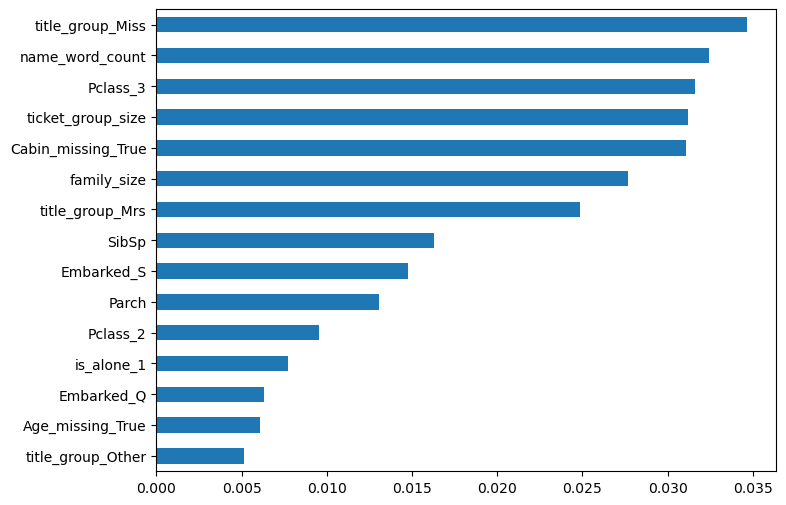

In [7]:
importance = pd.Series(
    rf.feature_importances_,
    index=predict.columns
).sort_values(ascending=True)

importance.head(15).plot(kind="barh", figsize=(8,6))

Could make some wild guesses right now, as women were let off first, longer names tend to denote wealthier class, pclass_3 is probably negative in that poor women survived less etc.

We'll now do some cross validation using rf's OOB estimates to save on processing power.

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

param_dist = {
    "n_estimators": randint(100, 1000),
    "max_depth": randint(3, 30),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rand_search = RandomizedSearchCV(
  rf, param_distributions=param_dist,
  n_iter=50, cv=10, scoring='accuracy',
  n_jobs=-1, random_state=42)

rand_search.fit(predict, response)

best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 919}


Seems like the best params are max depth of 28, features sqrt, min leafs 3, min splits 8, and n estimators 919, we can now generate a new rf model

In [9]:
rffinal = RandomForestClassifier(
    n_estimators=919,
    max_depth=28,
    max_features="sqrt",
    min_samples_leaf=3,
    min_samples_split=8,
    random_state=42,
    n_jobs=-1
)

rffinal.fit(predict, response)

model_pred = rffinal.predict(predict_test)

print("Accuracy:", accuracy_score(response_test, model_pred))
print(confusion_matrix(response_test, model_pred))
print(classification_report(response_test, model_pred))

Accuracy: 0.8071748878923767
[[118  19]
 [ 24  62]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       137
           1       0.77      0.72      0.74        86

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.81      0.81      0.81       223



The new hyper parameters improved accuracy by about 0.5%. Not too different from our initial guess but still an improvement overall.

<Axes: >

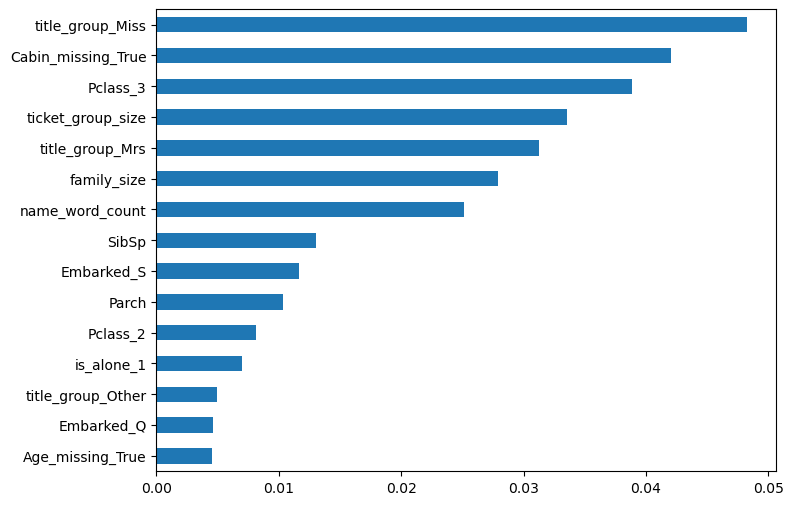

In [10]:
importance = pd.Series(
    rffinal.feature_importances_,
    index=predict.columns
).sort_values(ascending=True)

importance.head(15).plot(kind="barh", figsize=(8,6))

The importance graph is slightly different from before as well.

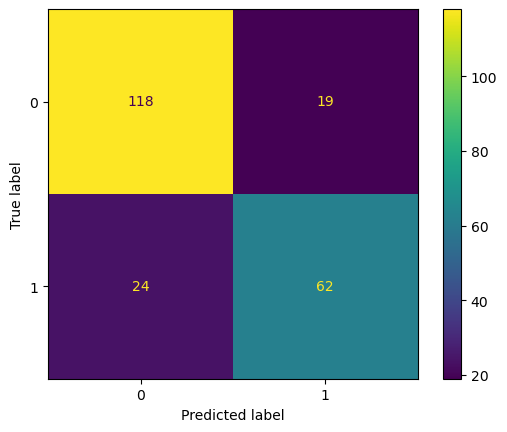

In [11]:
cm = confusion_matrix(response_test, model_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Confusion matrix doesn't look too off, there are slightly more false negatives (survived vs predicted dead) than false positives (dead vs predicted survived).

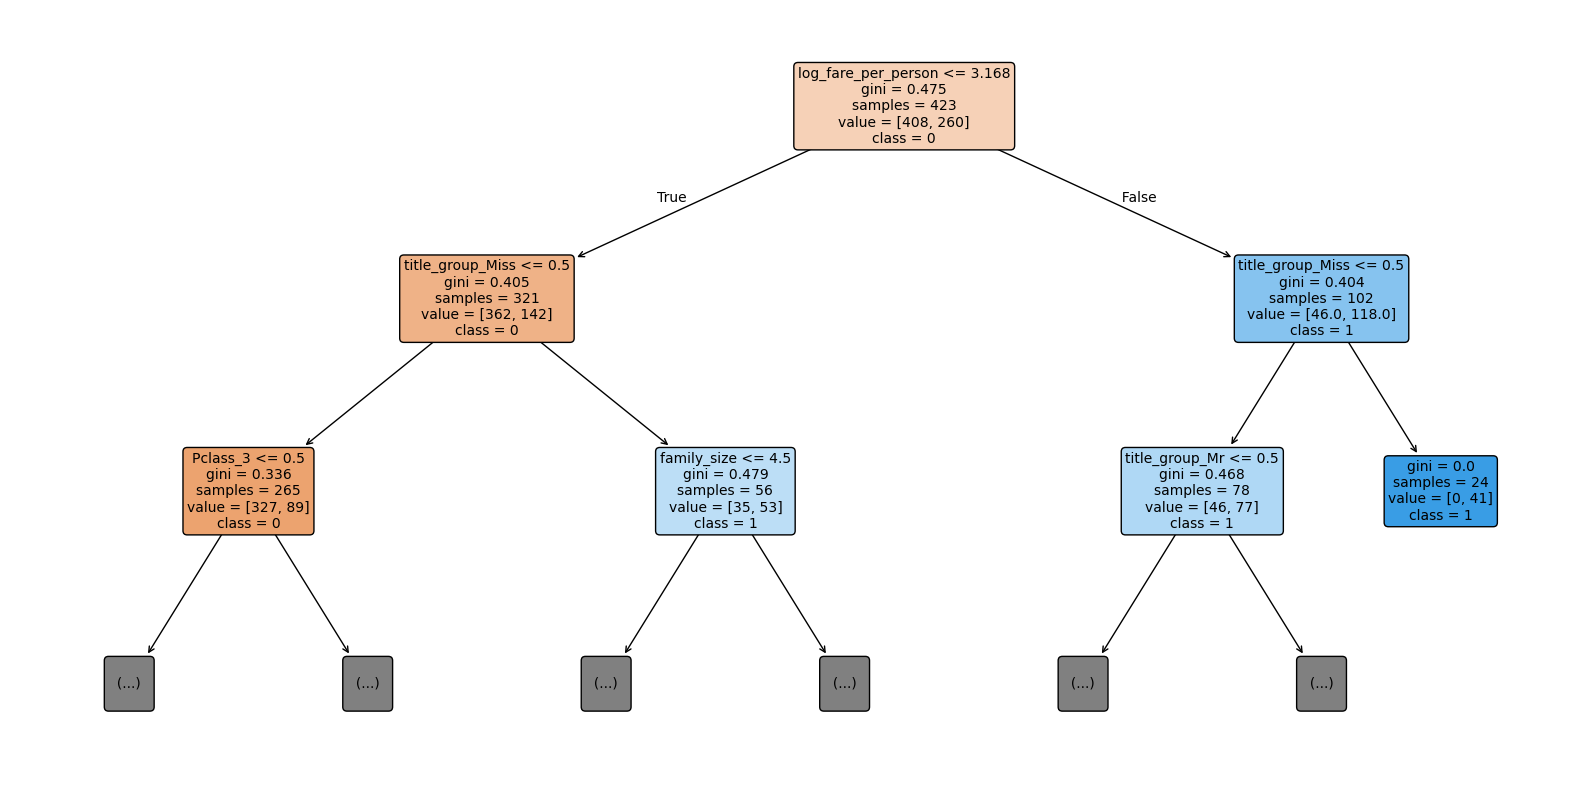

In [12]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plot_tree(
    rffinal.estimators_[0],     # pick any tree
    feature_names=predict.columns,
    class_names=rffinal.classes_.astype(str),
    max_depth=2,               # keep it shallow
    filled=True,
    rounded=True,
    fontsize=10
)

plt.show()

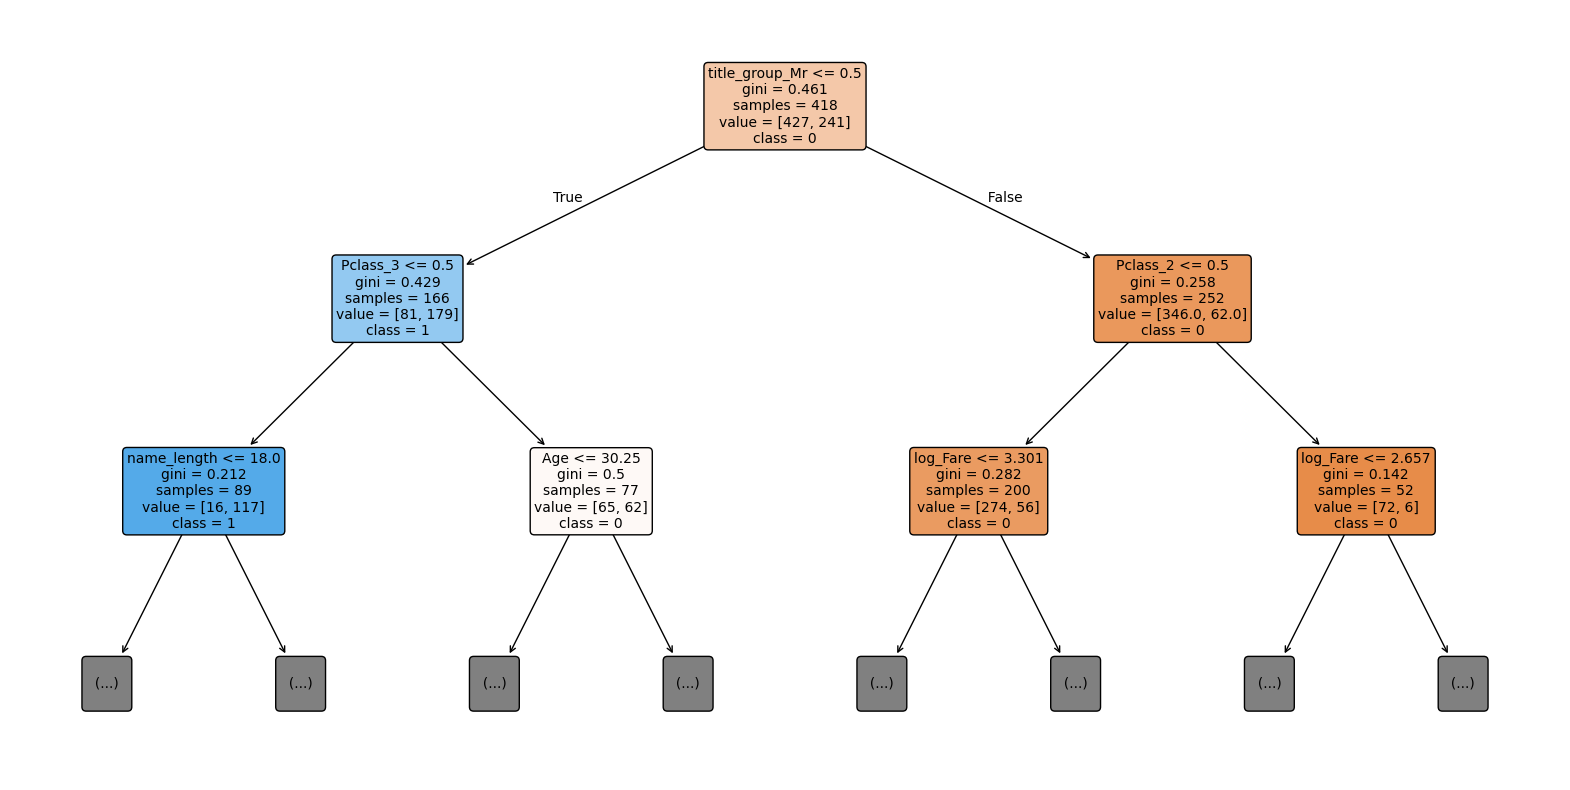

In [13]:
plt.figure(figsize=(20, 10))

plot_tree(
    rffinal.estimators_[500],     # pick any tree
    feature_names=predict.columns,
    class_names=rffinal.classes_.astype(str),
    max_depth=2,               # keep it shallow
    filled=True,
    rounded=True,
    fontsize=10
)

plt.show()

We also take a brief look at the 1st tree and the 501st tree in the model we generated, and they are different which is expected from RandomForests. We can also try gridsearchcv to see if that results in a better value. Note there's no random state as grid search tests every possibility.

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 20],
    'min_samples_leaf': [1, 30],
    'bootstrap': [True, False],
    "max_features": ["sqrt", "log2"]
}

gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=10)
gs.fit(predict, response)

,estimator,RandomForestClassifier()
,param_grid,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 30], 'min_samples_split': [2, 20], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,10


In [21]:
print("Best Parameters:", gs.best_params_)
print("Best Estimator:", gs.best_estimator_)

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Estimator: RandomForestClassifier(max_depth=10, n_estimators=10)


In [23]:
rfgs = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    bootstrap=True,
    n_jobs=-1
)

rfgs.fit(predict, response)

model_pred = rfgs.predict(predict_test)

print("Accuracy:", accuracy_score(response_test, model_pred))
print(confusion_matrix(response_test, model_pred))
print(classification_report(response_test, model_pred))

Accuracy: 0.7668161434977578
[[115  22]
 [ 30  56]]
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       137
           1       0.72      0.65      0.68        86

    accuracy                           0.77       223
   macro avg       0.76      0.75      0.75       223
weighted avg       0.76      0.77      0.76       223



This one is much worse than the randomsearchcv one so ignore it